In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict,  GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Exploring Titanic Survival with Classification Models

**Objective**: This project focuses on evaluating and preparing data to build classification models that predict passenger survival on the Titanic. Using the Titanic dataset from the Seaborn library, I explore data quality issues, handle missing and inconsistent values, and engineer relevant features. Multiple classification algorithms are trained and compared to assess their ability to predict the target variable (survived) and to better understand the factors associated with passenger survival.

# Data Exploration and Preparation

Load the Titanic DataFrame from Seaborn.

In [2]:
# load titanic dataset
titanic = sns.load_dataset('titanic')

For all features in the DataFrame, identify the number of instances with null values and the percentage of the feature that is null. 

In [3]:
# idenitify % null for each feature
titanic.isna().sum() / titanic.shape[0]

survived       0.000000
pclass         0.000000
sex            0.000000
age            0.198653
sibsp          0.000000
parch          0.000000
fare           0.000000
embarked       0.002245
class          0.000000
who            0.000000
adult_male     0.000000
deck           0.772166
embark_town    0.002245
alive          0.000000
alone          0.000000
dtype: float64

Remove the feature that is mostly null values.

In [4]:
# deck feature is more than 75% null values
titanic.drop(columns=['deck'], inplace=True)

This dataset includes four redundant features, that is separate features that represent equivalent information (alive & survived, class & pclass, embarked & embark_town, and adult_male & who).

In [5]:
# survived and alive present the same information
titanic_group = titanic.groupby(['survived','alive'], observed = True)
titanic_group[['survived','alive']].value_counts()

survived  alive
0         no       549
1         yes      342
Name: count, dtype: int64

In [6]:
# class and pclass present the same information
titanic_group = titanic.groupby(['class','pclass'], observed=True)
titanic_group[['class','pclass']].value_counts()

class   pclass
First   1         216
Second  2         184
Third   3         491
Name: count, dtype: int64

In [7]:
# embarked and embark_town present the same information
titanic_group = titanic.groupby(['embarked','embark_town'], observed=True)
titanic_group[['embarked','embark_town']].value_counts()

embarked  embark_town
C         Cherbourg      168
Q         Queenstown      77
S         Southampton    644
Name: count, dtype: int64

In [8]:
# adult_male and who present the same information
titanic_group = titanic.groupby(['adult_male','who'], observed=True)
titanic_group[['adult_male','who']].value_counts()

adult_male  who  
False       child     83
            woman    271
True        man      537
Name: count, dtype: int64

Drop the alive, class, embarked, and who input features from the dataset.

In [9]:
titanic.drop(columns=['alive','class','embarked','who'], inplace=True)

The feature adult_male was engineered from other features remaining in the input dataset.

In [10]:
# understand relationship between adult_male and age
titanic_group = titanic.loc[titanic.sex == 'male',].groupby(['adult_male'], observed=True)

# min age for adult males is 16
titanic_group['age'].min()

adult_male
False     0.42
True     16.00
Name: age, dtype: float64

In [11]:
# max age for non-adult males is 15
titanic_group['age'].max()

adult_male
False    15.0
True     80.0
Name: age, dtype: float64

The adult_male feature is engineered from features sex and age such that if sex is 'male' and age is greater or equal to 16, then adult_male is True.

Drop the adult_male input feature from the DataFrame.

In [12]:
titanic.drop(columns=['adult_male'], inplace=True)

Explore the data

In [13]:
# counts of passengers who died in the titanic by gender
titanic_group['sex'].value_counts() - titanic_group['survived'].sum()

adult_male  sex 
False       male     19
True        male    449
dtype: int64

In [14]:
# percentage of passengers that died by gender
1 - titanic_group['survived'].sum() / titanic_group['sex'].value_counts()

adult_male  sex 
False       male    0.475000
True        male    0.836127
dtype: float64

In [15]:
# counts of passengers who survived in the titanic by class
titanic_group = titanic.groupby(['pclass'],observed=True)
titanic_group['survived'].sum() /titanic_group['pclass'].value_counts()

pclass
1    0.629630
2    0.472826
3    0.242363
dtype: float64

In [16]:
# median fare by passenger class
titanic_group['fare'].median()

pclass
1    60.2875
2    14.2500
3     8.0500
Name: fare, dtype: float64

In [17]:
# max fare by passenger class
titanic_group['fare'].max()

pclass
1    512.3292
2     73.5000
3     69.5500
Name: fare, dtype: float64

In [18]:
# descriptive stats of non-null age values
titanic.age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64

In [19]:
# median age by class
titanic_group['age'].median()

pclass
1    37.0
2    29.0
3    24.0
Name: age, dtype: float64

Text(0.5, 1.0, 'Distribution of Age by Passenger Class')

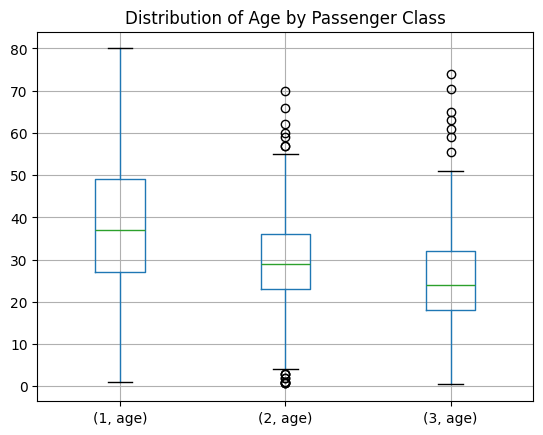

In [20]:
# boxplots of age by passenger class
titanic_group[['age']].boxplot(subplots=False)
plt.title('Distribution of Age by Passenger Class')

More men, 468, than women, 81, died on the Titanic. This means that 81% of male passengers died on the Titanic. This is a stark comparison to the 26% of female passengers that did not survive. By class, 63% of first class, 47% of second class, and only 24% of third class passengers survived. Fare varied widely on the Titanic both across and within passenger class. The median price of a first class ticket was $60 compared to the $8 median price of a third class ticket. The most expensive first class tickets were over $500. Passengers on the Titanic ranged from newborn to the elderly with passengers less than 1 year old and as old as 80. The median age was 37 for first class, 29 for second class, and 24 for third class passengers.

Drop the rows that are missing values in embark_town, and show the number of rows remaining in
the data set.

In [21]:
titanic.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embark_town      2
alone            0
dtype: int64

In [22]:
titanic.shape

(891, 9)

In [23]:
# drop records with missing values in embark_town
titanic.dropna(subset=['embark_town'], inplace=True)

In [24]:
titanic.shape

(889, 9)

Partition the data set into Training and Testing sets. Set aside 20% of the data for testing, and stratify on the target variable to maintain the imbalance in Training and Testing sets.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(titanic.drop(columns=['survived']), titanic[['survived']], stratify=titanic[['survived']], test_size=0.2, random_state=215)

In [26]:
X_train.shape

(711, 8)

In [27]:
y_train.shape

(711, 1)

In [28]:
X_test.shape

(178, 8)

In [29]:
y_test.shape

(178, 1)

Show that the target rate was maintained between the entire data set, Training data, and Testing data.

In [30]:
# check the percentage of passengers that survived in training set
titanic_group = y_train.groupby('survived')
titanic_group.value_counts() / y_train.shape[0]

survived
0    0.61744
1    0.38256
Name: count, dtype: float64

In [31]:
# check the percentage of passengers that survived in test set
titanic_group = y_test.groupby('survived')
titanic_group.value_counts() / y_test.shape[0]

survived
0    0.617978
1    0.382022
Name: count, dtype: float64

Null values are still present in the age input feature. From the Training Data, construct a stratified imputer that will replace missing age values with the median age by the passenger class. Employ this imputer to replace missing age values in the Training and Testing Data sets.

In [32]:
X_train.isna().sum()

pclass           0
sex              0
age            138
sibsp            0
parch            0
fare             0
embark_town      0
alone            0
dtype: int64

In [33]:
# compute median age for each class in training
median_age_by_pclass = X_train.groupby('pclass')['age'].median()

# impute median age for each class into missing values in train using training medians
X_train['age'] = X_train.apply(
    lambda row: median_age_by_pclass[row['pclass']] if pd.isna(row['age']) else row['age'],
    axis=1
)

# impute median age for each class into missing values in test using training medians
X_test['age'] = X_test.apply(
    lambda row: median_age_by_pclass.get(row['pclass'], X_train['age'].median())
    if pd.isna(row['age']) else row['age'],
    axis=1
)

In [34]:
X_train.isna().sum()

pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embark_town    0
alone          0
dtype: int64

In [35]:
X_test.isna().sum()

pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embark_town    0
alone          0
dtype: int64

Identify data types

In [36]:
X_train.dtypes

pclass           int64
sex             object
age            float64
sibsp            int64
parch            int64
fare           float64
embark_town     object
alone             bool
dtype: object

Review the data within the Training Data set, looking for categorical variables to be encoded.

In [37]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,embark_town,alone
203,3,male,45.5,0,0,7.2250,Cherbourg,True
597,3,male,49.0,0,0,0.0000,Southampton,True
301,3,male,24.0,2,0,23.2500,Queenstown,False
573,3,female,24.0,0,0,7.7500,Queenstown,True
601,3,male,24.0,0,0,7.8958,Southampton,True


In [38]:
X_train.pclass.unique()

array([3, 2, 1])

In [39]:
X_train.sex.unique()

array(['male', 'female'], dtype=object)

In [40]:
X_train.embark_town.unique()

array(['Cherbourg', 'Southampton', 'Queenstown'], dtype=object)

Pclass, sex, embark_town, and alone can all be considered categorical. 

Using the OneHotEncoder, encode the identified categorical features in the Training and Testing data set.

In [41]:
# list categorical features
categorical_features = ['pclass','sex','embark_town','alone']

# instantiate and fit encoder
encoder = OneHotEncoder(sparse_output=False, drop= 'first').fit(X_train[categorical_features])

In [42]:
# add instances back to training data
X_train[encoder.get_feature_names_out()] = encoder.transform(X_train[categorical_features])

# add instances back to the test data
X_test[encoder.get_feature_names_out()] = encoder.transform(X_test[categorical_features])

In [43]:
# remove original categorical feature
X_train.drop(columns=categorical_features, inplace=True)

# remove original categorical feature
X_test.drop(columns=categorical_features, inplace=True)

# Initial Model Training

Create instances of a logistic regression model, a support vector classifier, and a decision tree classifier.

In [44]:
# logistic regressor
logit = LogisticRegression(max_iter=1000)

# support vector machine
svm_class = svm.SVC(probability=True)

# decision tree
tree = DecisionTreeClassifier()

Calculate the probability predictions from each of the three classifiers.

In [45]:
# cross value predict for logistic regression
y_train_predict_logit = cross_val_predict(estimator=logit, X=X_train, y=y_train.to_numpy().ravel(), cv=5, method='predict_proba')

# cross value predict for SVM
y_train_predict_svm = cross_val_predict(estimator=svm_class, X=X_train, y=y_train.to_numpy().ravel(), cv=5, method='predict_proba')

# cross value predict for decision tree
y_train_predict_tree = cross_val_predict(estimator=tree, X=X_train, y=y_train.to_numpy().ravel(), cv=5, method='predict_proba')

Print a classification report, confusion matrix, and ROC-AUC score for each classifier.

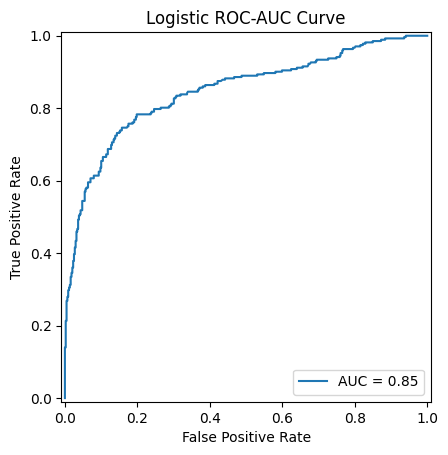

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       439
           1       0.77      0.69      0.73       272

    accuracy                           0.80       711
   macro avg       0.80      0.78      0.79       711
weighted avg       0.80      0.80      0.80       711



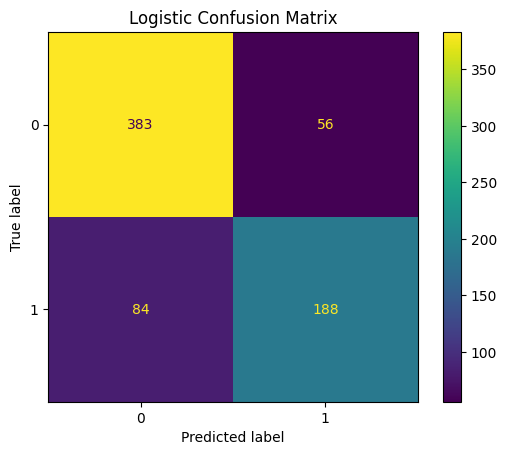

In [46]:
# class 1 probabilities
y_train_probabilities = y_train_predict_logit[:,1] 
# class 1 predictions
y_train_predictions = y_train_predict_logit[:,1] > 0.5 

## ROC-AUC Curve
# get false positive and true positive rates for Logistic Model
fpr, tpr, thresholds = roc_curve(y_train, y_train_probabilities)

# get auc score
roc_auc = auc(fpr, tpr)

# display plot
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()
plt.title('Logistic ROC-AUC Curve')
plt.show()

## Classification Report
print(classification_report(y_train, y_train_predictions))

## Confusion matrix
cm = confusion_matrix(y_train, y_train_predictions)

# display plot
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Logistic Confusion Matrix")
plt.show()

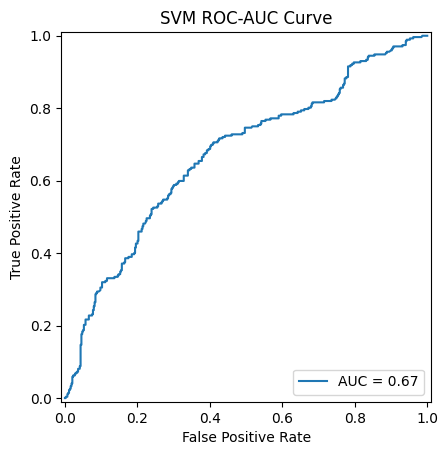

              precision    recall  f1-score   support

           0       0.67      0.91      0.77       439
           1       0.66      0.29      0.41       272

    accuracy                           0.67       711
   macro avg       0.67      0.60      0.59       711
weighted avg       0.67      0.67      0.63       711



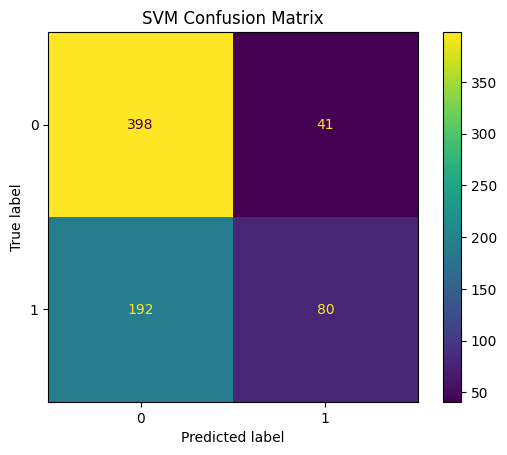

In [47]:
# class 1 probabilities
y_train_probabilities = y_train_predict_svm[:,1] 
# class 1 predictions
y_train_predictions = y_train_predict_svm[:,1] > 0.5 

## ROC-AUC Curve
# get false positive and true positive rates for Logistic Model
fpr, tpr, thresholds = roc_curve(y_train, y_train_probabilities)

# get auc score
roc_auc = auc(fpr, tpr)

# display plot
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()
plt.title('SVM ROC-AUC Curve')
plt.show()

## Classification Report
print(classification_report(y_train, y_train_predictions))

## Confusion matrix
cm = confusion_matrix(y_train, y_train_predictions)

# display plot
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("SVM Confusion Matrix")
plt.show()

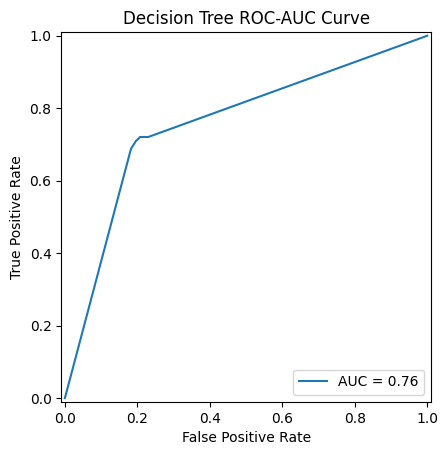

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       439
           1       0.70      0.69      0.69       272

    accuracy                           0.77       711
   macro avg       0.75      0.75      0.75       711
weighted avg       0.77      0.77      0.77       711



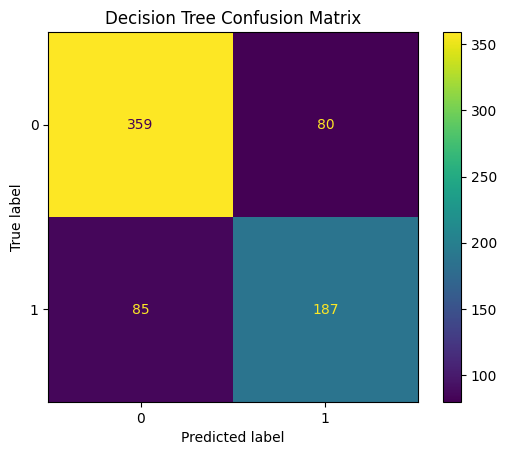

In [48]:
# class 1 probabilities
y_train_probabilities = y_train_predict_tree[:,1] 
# class 1 predictions
y_train_predictions = y_train_predict_tree[:,1] > 0.5 

## ROC-AUC Curve
# get false positive and true positive rates for Logistic Model
fpr, tpr, thresholds = roc_curve(y_train, y_train_probabilities)

# get auc score
roc_auc = auc(fpr, tpr)

# display plot
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()
plt.title('Decision Tree ROC-AUC Curve')
plt.show()

## Classification Report
print(classification_report(y_train, y_train_predictions))

## Confusion matrix
cm = confusion_matrix(y_train, y_train_predictions)

# display plot
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Decision Tree Confusion Matrix")
plt.show()

# Model Tuning

The training and testing data was not standardized in previous steps. Employing StandardScaler, fit
and transform the training and testing data sets.

In [49]:
# instantiate standard scaler
scaler = StandardScaler()

# fit scaler to training set
scaler.fit(X_train)

# scale data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# transform to dfs
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

Recalculate the probability predictions for the Support Vector Classifier, and print the classification report, confusion matrix, and ROC-AUC score.

In [50]:
# cross value predict for SVM with scaled data
y_train_predict_svm_scaled = cross_val_predict(estimator=svm_class, X=X_train_scaled, y=y_train.to_numpy().ravel(), cv=5, method='predict_proba')

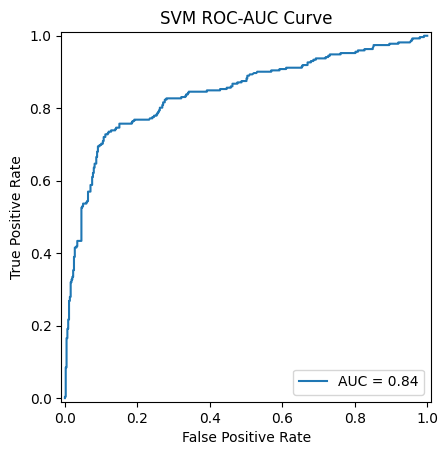

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       439
           1       0.81      0.70      0.75       272

    accuracy                           0.82       711
   macro avg       0.82      0.80      0.81       711
weighted avg       0.82      0.82      0.82       711



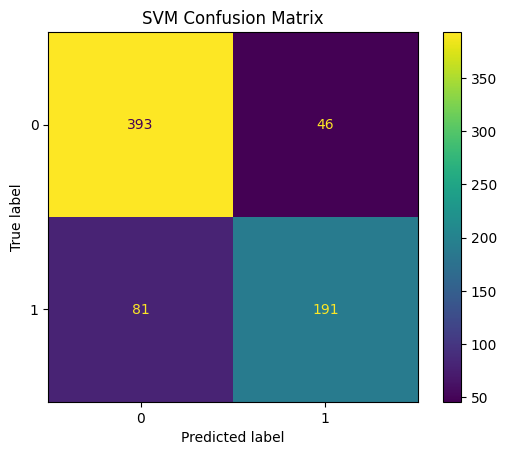

In [51]:
# class 1 probabilities
y_train_probabilities = y_train_predict_svm_scaled[:,1] 
# class 1 predictions
y_train_predictions = y_train_predict_svm_scaled[:,1] > 0.5 

## ROC-AUC Curve
# get false positive and true positive rates for Logistic Model
fpr, tpr, thresholds = roc_curve(y_train, y_train_probabilities)

# get auc score
roc_auc = auc(fpr, tpr)

# display plot
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()
plt.title('SVM ROC-AUC Curve')
plt.show()

## Classification Report
print(classification_report(y_train, y_train_predictions))

## Confusion matrix
cm = confusion_matrix(y_train, y_train_predictions)

# display plot
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("SVM Confusion Matrix")
plt.show()

Support Vector Machines (SVMs) are sensitive to the scale of input features. When using unscaled X_train data for our SVM model, we had low accuracy, 67% and precision, 66%, and very low recall, 29%, due to the model's high false negative rate. After scaling our input features, the model improved signifigantly to a 82% accuracy, 81% precision, and 70% recall rate. False negatives continue to hinder the model's performance but to a much lesser extent with the scaled inputs.



Hyperparametertune the Support Vector Classifier.

In [52]:
param_grid = {'kernel': ['rbf'],
    'gamma':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5],
    'C':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

svm_grid_search = GridSearchCV(estimator=svm_class,
                                param_grid=param_grid,
                                cv=5,
                                scoring='roc_auc'
                                )

svm_grid_search.fit(X_train_scaled, y_train.to_numpy().ravel())

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
                         'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5],
                         'kernel': ['rbf']},
             scoring='roc_auc')

Print the best parameters and the corresponding best score.

In [53]:
# optimal parameters
svm_grid_search.best_params_

{'C': 0.5, 'gamma': 0.005, 'kernel': 'rbf'}

In [54]:
# best score
svm_grid_search.best_score_

np.float64(0.8532086407439072)

With the best estimator from the fitted GridSearchCV object, make predictions with the scaled Testing data set, and present the classification report, confusion matrix, and ROC-AUC score.

In [55]:
# best model
best_model = svm_grid_search.best_estimator_

# predict using best model
y_test_predict_svm = best_model.predict_proba(X_test_scaled)

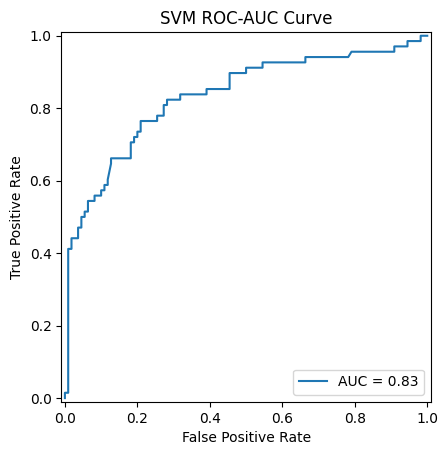

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       110
           1       0.70      0.68      0.69        68

    accuracy                           0.76       178
   macro avg       0.75      0.75      0.75       178
weighted avg       0.76      0.76      0.76       178



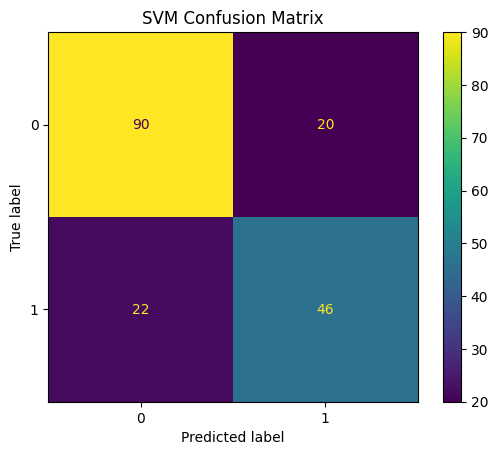

In [56]:
# class 1 probabilities
y_test_probabilities = y_test_predict_svm[:,1] 
# class 1 predictions
y_test_predictions = y_test_predict_svm[:,1] > 0.5 

## ROC-AUC Curve
# get false positive and true positive rates for Logistic Model
fpr, tpr, thresholds = roc_curve(y_test, y_test_probabilities)

# get auc score
roc_auc = auc(fpr, tpr)

# display plot
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()
plt.title('SVM ROC-AUC Curve')
plt.show()

## Classification Report
print(classification_report(y_test, y_test_predictions))

## Confusion matrix
cm = confusion_matrix(y_test, y_test_predictions)

# display plot
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("SVM Confusion Matrix")
plt.show()